In [211]:
# Standardopsætning (kør denne først)
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42) # YEAH 42

# Dansk labels i figurer
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# PCG og mekaniske hændelser: Filtering og feature-timing

**Udtræk og visualisering af SCG/PCG-data**

I denne lektion arbejder vi med:
- **PCG (Phonocardiography)**: Hjertelyde optaget via stetoskop

**Fokus:**
- Indlæsning og inspektion af PCG-data
- Forståelse af hvad signaler består 
- Visualisering med subplots for sammenligning
- Forberedelse til filtrering og feature-ekstraktion


# Mål for dagens forelæsning

- Forstå SCG/PCG signaler og deres frekvensindhold
- Finde S1 og S2 lyde
- Synkronisér events/features mellem ECG og SCG (R→S1,S2 timing)
- Kvantificér variabilitet med histogrammer



## Finde S1 og S2 lyde

- Filtrér signalet zero‑phase (Butterworth + filtfilt) for tydelige events. (Gøres nedenfor: Welch/Butterworth + filtrering)
- Beregn envelopen af det filtrerede signal. (Gøres nedenfor: Envelope‑funktionen)
- Find peaks i envelopen med passende `distance` og `prominence`. (Gøres nedenfor: Peak‑detektion)
- Beregn tidsafstande mellem peaks. (Gøres nedenfor: Intervaller)
- Klassificér S₁ og S₂ ud fra korte/lange intervaller. (Gøres nedenfor: Klassifikation)
- Validér med histogram over intervaller. (Gøres nedenfor: Histogram)
## Data Workflow

```mermaid
flowchart LR
    A[**Load Data**] --> B[**Inspect**]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

## For at finde S1 og S2 skal I kunne:

**Signalforbehandling (Data Preparation)**
- Inspicere rå data: skalering, outliers, artefakter
- Vælge passende filtre baseret på frekvensindhold (spectral analyse)
- Anvende zero-phase filtrering uden tidsforskydning

**Feature‑detektion (Feature Finding)**
- Beregne envelope til at fremhæve events
- Finde lokale maxima (peaks) med robuste parametre
- Kvantificere afstande mellem features

**Feature‑klassifikation (Classification)**
- Skelne mellem feature-typer via tidsintervaller eller anden kontekst
- Anvende fysiologiske regler til at mærke events
- Validere klassifikation mod vidtkendte mønstre

**Analyse & Kommunikation**
- Visualisere både signal og features
- Bruge histogrammer til at vurdere variabilitet og outliers
- Dokumentere valgte parametre og deres begrundelse

👉 **Generalisering**: Disse trin gælder for alle signalanalyse-opgaver — EMG, EEG, accelerometer, osv.


## Dagens struktur – kort overblik

1. **Hvad er PCG?** – Lyd fra hjertet, frekvensindhold, udfordringer
2. **Filtrering** – Valg af cut-off via spektrum, zero-phase (Butterworth)
3. **Envelope** – Sådan fremhæves hjertelydene
4. **Peak-detektion** – Find S1 og S2 i envelopen
5. **Klassifikation** – S1 vs. S2 via tidsintervaller
6. **Validering** – Histogram over intervaller, variabilitet

**Øvelse:** Design en pipeline og test på rigtigt data.


### Brug histogram til at fjerne for-/baggrundsstøj
- Afslør baggrundsstøj vs. signal ved fordelingens form
- Se efter brede/skæve fordelinger (støj) vs. skarpe toppe (signal)
- Eksempel nedenfor med tilfældigt datasæt (støj): waveform + histogram

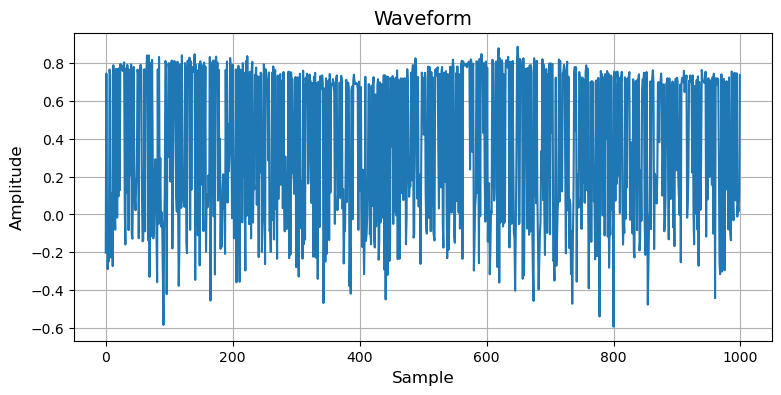

In [212]:
d = np.loadtxt("files/random_dist.csv")
t = np.arange(len(d))
plt.plot(t,d)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()


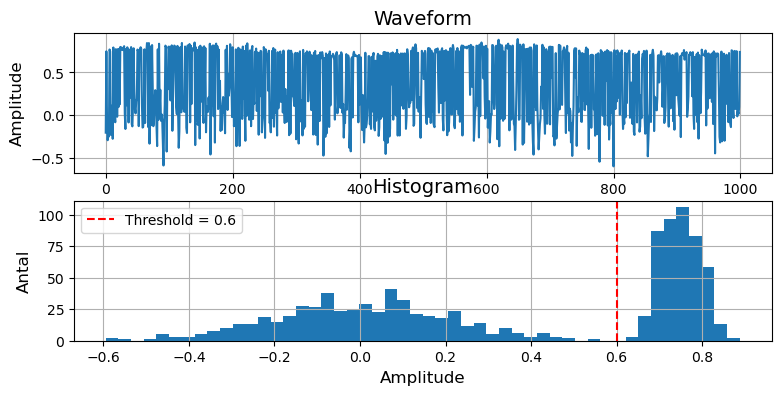

In [213]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t,d)
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Waveform")
axs[1].hist(d,   bins=50)
axs[1].axvline(x=0.6, color='r', linestyle='--', label=f'Threshold = {0.6}')
axs[1].set_xlabel("Amplitude")
axs[1].set_ylabel("Antal")
axs[1].set_title("Histogram")
axs[1].legend()
plt.show()


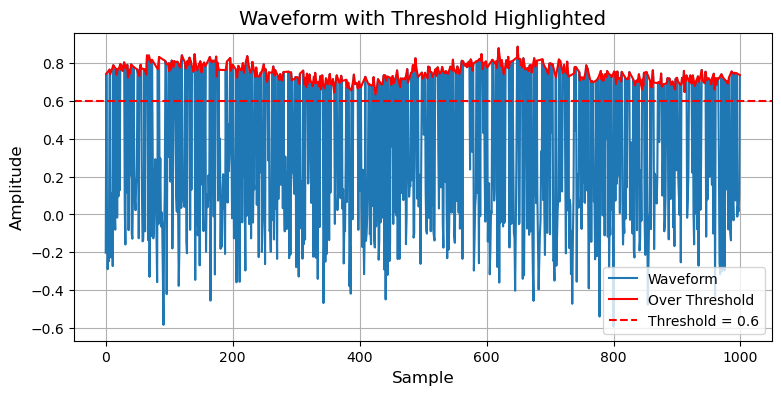

In [214]:
threshold = 0.6
# tid og værdi for samples over / under threshold
t_over = t[d > threshold]
d_over = d[d > threshold]
plt.plot(t,d, label="Waveform")
plt.plot(t_over, d_over, 'r', label="Over Threshold")
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform with Threshold Highlighted")
plt.legend()
plt.show()  

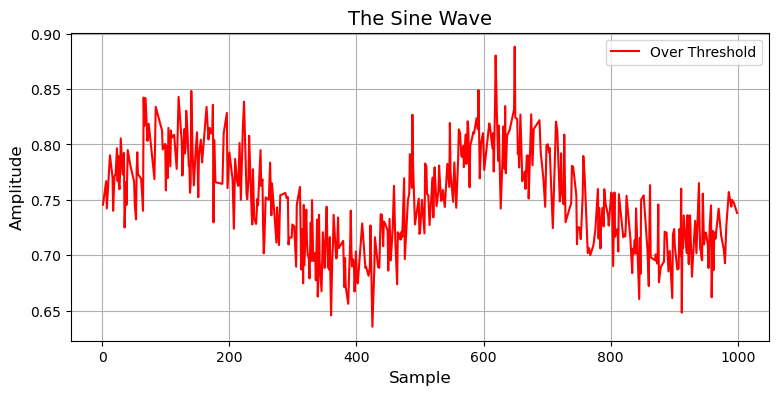

In [215]:
plt.plot(t_over, d_over, 'r', label="Over Threshold")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("The Sine Wave")
plt.legend()
plt.show()  

### Exercise: Load data fra fil
**Kort genopfriskning fra sidste time:**
- Load `timestamp`, `ecg`, `pcg` fra `files/ECGPCG.csv` med `np.loadtxt()`
- Skipper første linje (column headers) med `skiprows=1`
- Plot begge signaler for at inspicere dem

Vi bruger samme data nu til S1/S2-detektion.

### Answer
Den naive løsning er at man bare plotter det hele i et enkelt plt. 

Lad os gøre det.

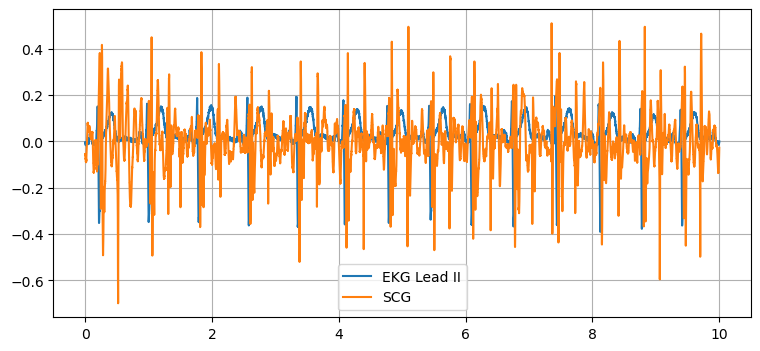

In [216]:
import numpy as np
import matplotlib.pyplot as plt
filename = "files/ECGPCG.csv"
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)

plt.plot(timestamp, ecg, label="EKG Lead II")
plt.plot(timestamp, pcg, label="SCG")
plt.legend()
plt.show()


## Subplots giver overblik

* Adskiller signaler og reducerer visuel støj
* Muliggør direkte sammenligning via fælles tidsakse
* Tillader korrekt skalering af hvert signal
* Forbedrer læsbarhed og fortolkning


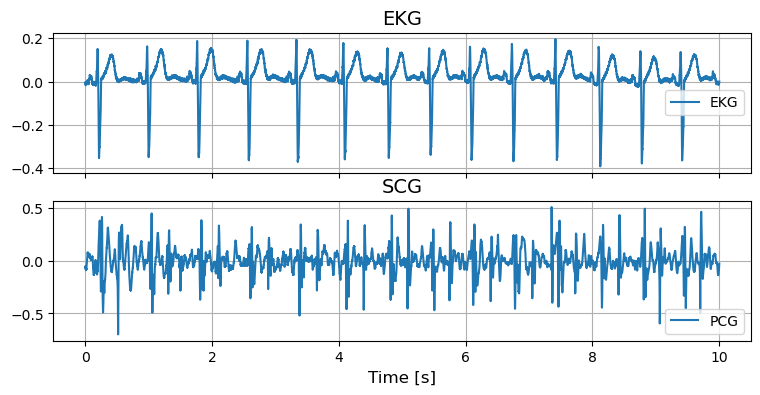

In [217]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(timestamp, ecg, label="EKG")
axs[0].legend()
axs[0].set_title("EKG")
axs[1].plot(timestamp, pcg, label="PCG")
axs[1].legend()
axs[1].set_xlabel("Time [s]")
axs[1].set_title("SCG")
plt.show()

## Clean Data

```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[**Clean**]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

# Exercise: moving average (mov)?
**Scenarie:**

Du arbejder som ingeniør på et hospital, hvor du skal hjælpe med at analysere hjertelyde fra patienter. Et af problemerne er, at optagelserne ofte indeholder både hjertelyde og baggrundsstøj fra omgivelserne (fx snak, apparater, bevægelser). For at kunne analysere hjertelydene korrekt, skal støjen fjernes fra signalet, så S1 og S2 bliver tydeligere, uden at vigtige detaljer forsvinder.

**Du ved:**

* Hvordan man filtrerer med et moving average filter


**Opgave:**
1. Hver især (altså ikke flere på samme PC); I programmet `files/adjust_mov_practice.py` ændre `window` til en størrelse så DU mener at signalet er godt.
2. Snak med hinanden:
    - Argumenter for dit `window` valg, og hvorfor det er bedre! (I skal ikke ændre jeres valg)
    - Hvad ved I ved omkring et PCG signal.
    - Fjerner moving average højfrekvens eller lavfrekvens støj?
    - Giver et moving average filter mening?
    - Hvad er støj?

## Svar
- Data er gemt med 8000Hz.
- Men hvorfor siger jeg det?

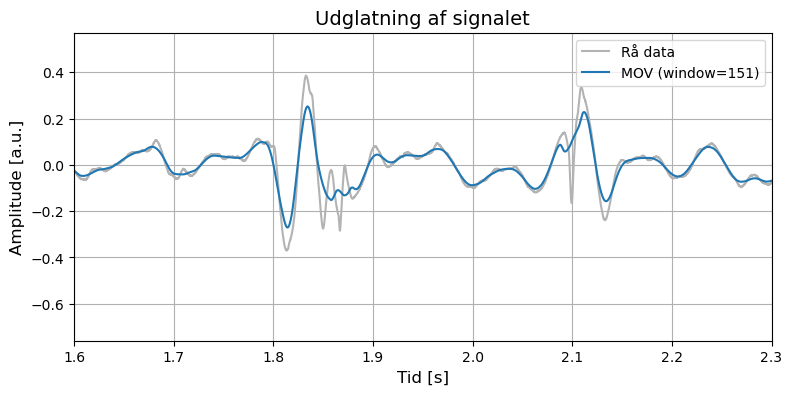

In [218]:
# %load files/adjust_mov_practice.py
# Moving average (for reference)
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, filtfilt, medfilt
import numpy as np
import matplotlib.pyplot as plt

# Juster window 
window = 151
filename = "files/ECGPCG.csv" # Hvis du får en FileNotFoundError, prøv at fjern "files/" fra string.

"""
Lad være med at ændre noget herunder. 
OGSÅ selvom i får en error.
(det gør i bl.a. hvis window er et lige tal)
"""
fs = 8000 # sample rate Hz

# HEY LOOK; Du kan også bare loade specifikke columns! (der er 5 columns i filen)
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)

x = pcg # 4 sekunder af SCG signalet
t = timestamp 

# moving average filter (du kan lave et MOV på MANGE måder)
x_ma = uniform_filter1d(x,window)

plt.figure()
plt.plot(t, x, color='0.7', label='Rå data')
plt.plot(t, x_ma, label=f'MOV ({window=})')
plt.title('Udglatning af signalet')
plt.xlabel('Tid [s]')
plt.ylabel('Amplitude [a.u.]')
plt.xlim([1.6, 2.3])
plt.legend()
plt.show()


- Der er ikke noget godt svar for en window size.
  - Dette er fordi S1 og S2 signalerne bl.a. indeholder **lavfrekens** støj. 
  - MOV fjerner de højere frekvenser

# Know Your Data!!!
```mermaid
flowchart LR
    A[Load Data] --> B[**Inspect**]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```
**Hvad er et PCG?**
- PCG: Phonocardiography 
- Det er et stetoskop.
- $20Hz < \textbf{det menneskelige auditive spektrum} < 20 000 Hz$



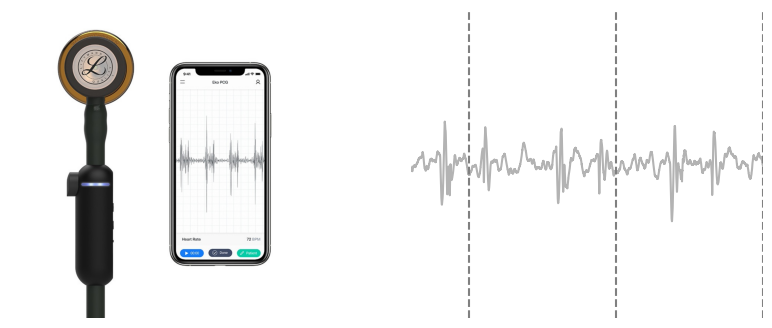

In [219]:
fig, axs =plt.subplots(1,2, figsize=(10,4))
axs[0].imshow(plt.imread("files/stetoskop.jpg"))
axs[0].axis('off')               # hides axes and ticks

axs[1].plot(t, x, color='0.7', label='Rå data')
axs[1].set_xlim([1.6, 4])
axs[1].set_ylim(np.array([-1.3,1.5])-0.1)
# vertical line at 2.1 s
for i in range(5):
    axs[1].axvline(x=i, color='gray', linestyle='--', label='Hjerte lyd')
axs[1].axis('off')               # hides axes and ticks
plt.show()


# Afspilning af en fil
For at spille en lydfil gennem python (Ikke Jupyter!), kan man bruge pakken `sounddevice`,
herefter kan man fx køre programmet `files/play_sound.py`

>```python 
>import sounddevice as sd
>from scipy.signal import resample
>import numpy as np
>filename = "files/b001.csv"
>data = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True, usecols=[3])
>fs = 5000 # orginal sampling frekvens
># sounddevice kan ikke finde ud af 5000Hz, så vi konverterer det om (resampler) til 44100Hz
>fs_new = 44100 # Normal 
>num_samples = int(len(data) * fs_new / fs)
>data_resampled = resample(data, num_samples)
>sd.play(data_resampled, fs_new)
>sd.wait()           # Wait until playback finishes
>```



In [220]:
from IPython.display import Audio
Audio(pcg, rate=fs,normalize=True)

# Hvor kommer S₁ og S₂ fra?

<div style="display: flex; align-items: flex-start; gap: 30px;">
    <div style="flex: 1;">
        <h3>S₁ – <em>første hjertelyd</em></h3>
        <ul>
            <li>Opstår når <strong>mitralklappen og trikuspidalklappen lukker</strong></li>
            <li>Marker starten på <strong>systolen</strong> (hjertets pumpefase)</li>
            <li>Ofte beskrevet som <strong>"lub"</strong></li>
            <li>Har typisk <strong>lavere frekvens</strong> og lidt længere varighed</li>
        </ul>
        <h3>S₂ – <em>anden hjertelyd</em></h3>
        <ul>
            <li>Opstår når <strong>aortaklappen og pulmonalklappen lukker</strong></li>
            <li>Marker slutningen af systolen / starten på <strong>diastolen</strong></li>
            <li>Ofte beskrevet som <strong>"dub"</strong></li>
            <li>Typisk <strong>kortere og lidt højere frekvens</strong> end S₁</li>
        </ul>
    </div>
    <div style="flex: 0 0 400px;">
        <img src="files/hjete.png" alt="hjertet" style="width: 100%; max-width: 400px;">
    </div>
</div>

# Clean + Vizualize
### Valg af cut-off via spektral information (Spektral / Frekvens Spektret)



```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[Clean]
    C --> D[**Visualize**]
    D --> E[Extract Features]
    E --> F[Store]
```

**Sådan finder man LUB DUB**
- Brug **Welch‑PSD** til at se hvor energien ligger.  
- Sæt lavpas hvor du mener hovedindholdet af hjertelydene er for at fjerne lav frekvens støj, men bevare events.


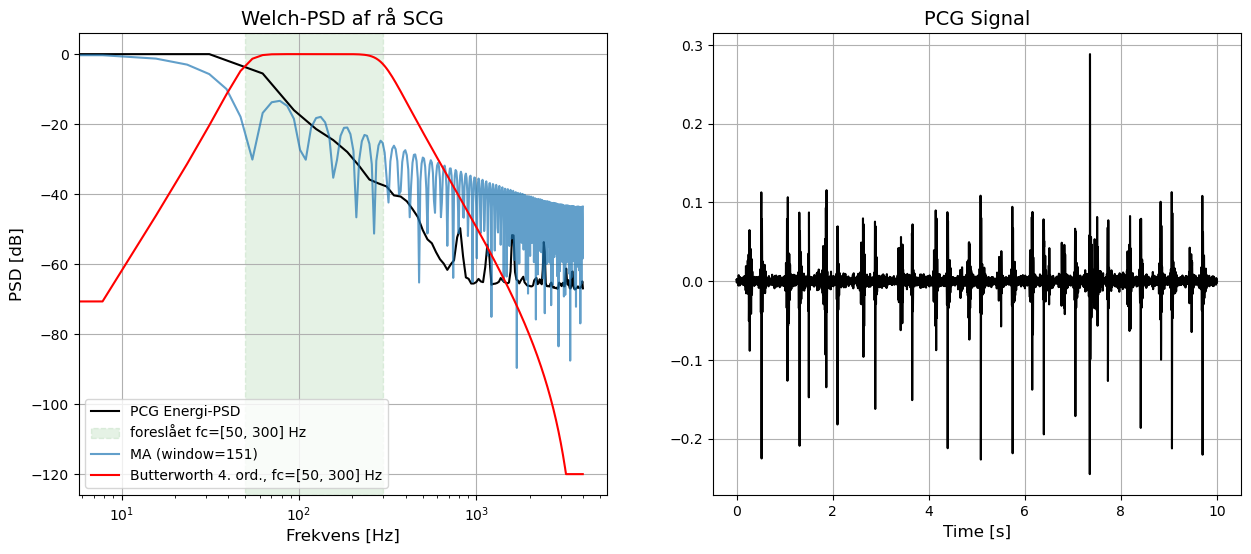

In [221]:
# Welch-PSD for at motivere cut-off

from scipy.signal import butter, freqz, filtfilt, welch
fs=8000
w_ma = np.ones(window)/window
# MA frekvensrespons via FFT af kernel
W_m = np.fft.rfft(w_ma, 1024)
f_ma = np.fft.rfftfreq(1024, d=1/fs)
fc = [50,300]
b, a = butter(4, fc, fs=fs, btype='bandpass') 
w, H = freqz(b, a, fs=fs)

filter_XY_MA = (f_ma, 20*np.log10(np.maximum(np.abs(W_m), 1e-6)), f'MA ({window=})')
filter_XY_Butterworth = (w, 20*np.log10(np.maximum(np.abs(H), 1e-6)), f'Butterworth 4. ord., {fc=} Hz')


f, Pxx = welch(x, fs=fs)
# convert Pxx to dB
#ensure that Pxx starts at 0db
Pxx = Pxx / np.max(Pxx)
Pxx_dB = 10 * np.log10(Pxx + 1e-12)  # Adding a small value to avoid log(0)

# Butterworth zero-phase
b, a = butter(4, fc, fs=fs, btype='bandpass') # type: ignore
lubdub = filtfilt(b, a, x)
t_lubdub = np.linspace(0,len(lubdub)/fs, len(lubdub))
# Visualize
fig,axs = plt.subplots(1,2, figsize=(15,6))
axs[0].semilogx(f, Pxx_dB, label='PCG Energi-PSD', color='black')
axs[0].axvspan(xmin=fc[0],xmax=fc[1], color='green', linestyle='--', label=f'foreslået {fc=} Hz', alpha=0.1)
axs[0].semilogx(filter_XY_MA[0], filter_XY_MA[1], label=filter_XY_MA[2], alpha=0.7)
axs[0].semilogx(filter_XY_Butterworth[0], filter_XY_Butterworth[1], label=filter_XY_Butterworth[2],  color='red')     
axs[0].set_title('Welch-PSD af rå SCG')
axs[0].set_xlabel('Frekvens [Hz]')
axs[0].set_xscale("log")
axs[0].set_ylabel('PSD [dB]')
axs[0].legend()
axs[1].plot(t_lubdub,lubdub, color='black')
axs[1].set_title('PCG Signal')
axs[1].set_xlabel('Time [s]')


plt.show()

In [222]:

from IPython.display import Audio
Audio(lubdub, rate=fs,normalize=True)

# Detektion af S1 og S2
```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[**Extract Features**]
    E --> F[Store]
```

## Overblik: idéen bag S₁ / S₂-detektion

1. Beregn **Envelopen** af PCG-signalet
2. Find **lokale maxima (peaks)** i envelopen
3. Brug **tidsafstande mellem peaks** til at skelne S₁ og S₂

![Image](files/S1S2_1.jpg)
![Image](files/S1S2_2.jpg)


## Det vigtige fysiologiske trick

I én hjertesyklus gælder typisk:

* **S₁ → S₂** : *kort interval* (systole)
* **S₂ → næste S₁** : *længere interval* (diastole)

Det betyder:

> **S₁ er den peak, der kommer efter den længste pause**

# **The Envelope**

Når du lytter med et stetoskop, er dit rå signal en blanding af:
* S₁ og S₂ (de dominerende lyde)
* Eventuelle ekstra hjertelyde (S₃, S₄)
* Støj fra vejrtrækning og omgivelser

**Envelop**:

* Følger signalets energi / amplitude
* Gør det meget lettere at se og detektere S₁ og S₂ som peaks
* Ofte bruges som første trin i automatisk hjertelydsanalyse




## Hvad er en envelope?

En **envelope** er et “tæppe” lagt over et signal, som fremhæver dets overordnede form og hjælper med at tydeliggøre vigtige elementer.

Eksempel: Stetoskop-signaler med **S₁** og **S₂** hjertelyde.

---

## Hvorfor bruge en envelope?

* Fremhæver signalets amplitudeændringer
* Gør mønstre lettere at se
* Hjælper med analyse af komplekse signaler



## Envelope Extraction
>```sh
>FUNKTION envelope(signal, window): 
>   BEREGN mean_value = gennemsnit af signal
>   s0 = signal - mean_value
>   r = absolut værdi af s0
>   OPRET mov_max som tomt array med samme længde som r
>   FOR HVER indeks i FRA 0 TIL længde af r:
>     start = maksimum af (i - half_w, 0)
>     end = minimum af (i + half_w + 1, længde af r)
>     mov_max[i] = maksimum værdi i r[start:end]
>  env = mov_max + mean_value
>  RETURNER env
```


(2.5, 4.0)

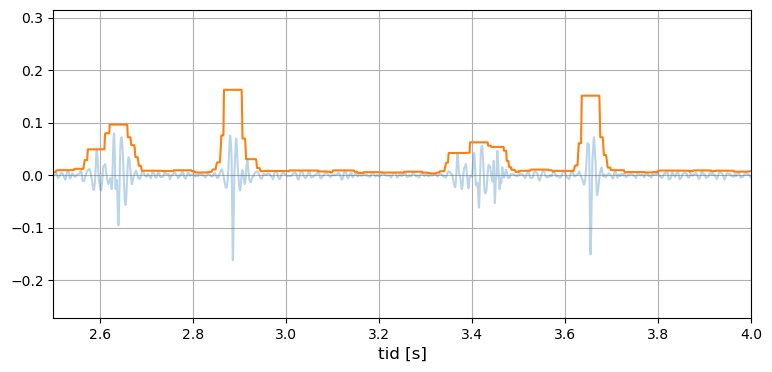

In [223]:
import numpy as np

def envelope(x, window=50):
    """
    Beregn en envelope for et signal x.
    """
    # 1. Fjern gennemsnittet
    mean_x = np.mean(x)
    s0 = x - mean_x

    # 2. Rectify (absolut værdi)
    r = np.abs(s0)

    # 3. Moving Maximum
    mov_max = np.zeros_like(r)
    half_w = window // 2
    for i in range(len(r)):
        start = max(i - half_w, 0)
        end = min(i + half_w + 1, len(r))
        mov_max[i] = np.max(r[start:end])

    # 4. Tilføj gennemsnittet tilbage
    env = mov_max + mean_x
    return env

e = envelope(lubdub,window=301)
plt.plot(t_lubdub,lubdub, label="lubdub", alpha=0.3)
plt.plot(t_lubdub,e, label="envelope")
plt.xlabel("tid [s]")
plt.xlim([2.5, 4])

### Find peaks i envelopen

>```python
> from scipy.signal import find_peaks
> # distance afhænger af fs; prominence/height styrer robusthed
> def Envelope(sig:np.ndarray):...
> fs = 8000
> e = Envelope(sig)
> peaks, _ = find_peaks(e, distance=int(0.15*fs), height=np.std(e))
> peak_tidspunkter = peaks / fs
>```

# Klassificér S₁ og S₂

> ```sh
> FUNKTION klassificer_S1_S2(peaks): 
>    # Trin 1: Beregn tidsafstande mellem peaks
>    intervals = BEREGN forskelle mellem consecutive peaks
>    
>    # Trin 2: Initialiser arrays til S₁ og S₂
>    S1 = TOM LISTE
>    S2 = TOM LISTE
>    
>    # Trin 3: Klassificér hver peak baseret på forrige interval
>    FOR HVER peak index i FRA 1 TIL (antal peaks - 1):
>        
>        HVIS intervals[i-1] < intervals[i]:
>            # Peak kommer efter LANG pause → S₁
>            TILFØJ peaks[i] TIL S1
>        ELLERS:
>            # Peak kommer efter KORT pause → S₂
>            TILFØJ peaks[i] TIL S2
>    
>    RETURNER S1, S2
> ```

## Histogram – hvad og hvornår?
- Viser fordelingen af værdier (fx peak‑til‑peak intervaller)
- Bruges til at vurdere variabilitet, outliers og stabilitet
- God til at sammenligne før/efter filtrering eller forskellige parametre

I denne kontekst: histogrammet af mekaniske intervaller viser rytme/variabilitet og hjælper med S₁/S₂‑klassifikation

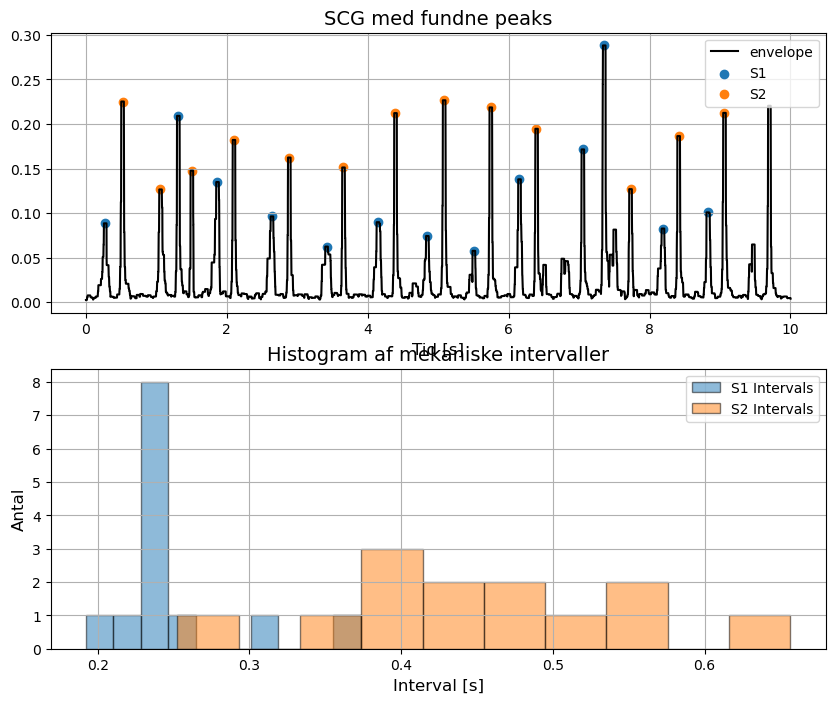

In [224]:
# Histogram af peak-til-peak intervaller
from scipy.signal import find_peaks
import numpy as np

# Peaks i envelopen
pks, _ = find_peaks(e, distance=int(0.15*fs), height=np.std(e))
intervals = np.diff(pks)/fs
S1: list[list[float]] = []
S2: list[list[float]] = []
# Find S1 and S2 intervals + the peak value

for i in range(len(intervals)-1):

    if intervals[i] < intervals[i+1]:
        S1.append([intervals[i], pks[i]/fs, e[pks[i]]])
    else:
        S2.append([intervals[i], pks[i]/fs, e[pks[i]]])



fig, axs = plt.subplots(2,1, figsize=(10,8)); 
axs[0].plot(t_lubdub,e, label="envelope", color='black')
axs[0].scatter([x[1] for x in S1], [x[2 ] for x in S1], label='S1')
axs[0].scatter([x[1] for x in S2], [x[2 ] for x in S2], label='S2')
axs[0].set_xlabel("Tid [s]")
axs[0].set_title('SCG med fundne peaks');
axs[0].legend(loc='upper right')

axs[1].hist([x[0] for x in S1], edgecolor='k', alpha=0.5, label='S1 Intervals')
axs[1].hist([x[0] for x in S2], edgecolor='k', alpha=0.5, label='S2 Intervals')
axs[1].set_title('Histogram af mekaniske intervaller')
axs[1].set_xlabel('Interval [s]')
axs[1].set_ylabel('Antal')
axs[1].legend(loc='upper right')
plt.show()


---

# Workshop: S1/S2-detektion i praksis

Nu sætter I det hele sammen. Fokus: **zero‑phase filtrering**, **peak‑detektion**, **klassifikation** og **validering**.

## Filtrering uden tidsforskydning
**1. Scene og mål:** Et SCG‑signal skal glattes uden at forskyde AO‑tidspunkterne.  
**2. Hvad I ved/skal bruge/udbytte:** `butter` + `filtfilt`, `medfilt`. Forstå trade‑offs mellem glatning og peak‑bevaring.  
**3. Opgave:** Anvend Butterworth-filter på SCG, **kvantificér** tidsforskydning ved at sammenligne top‑tidspunkter før/efter, og **argumentér** for dit valg.

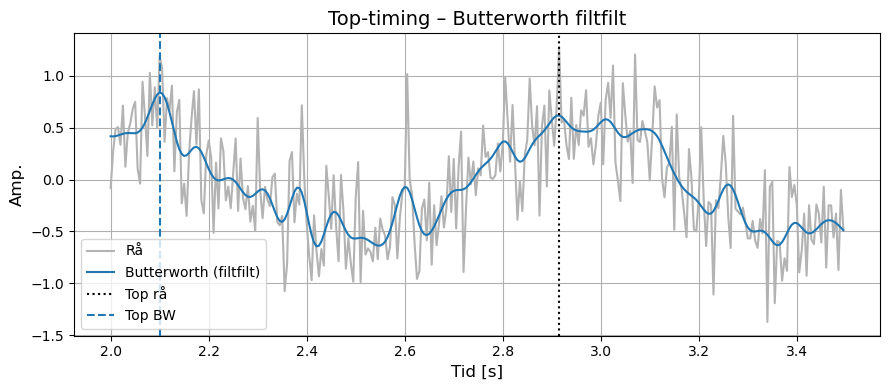

Δt BW vs. rå: -815.0 ms


In [225]:
# Svarskitse – filtrering uden lag

from scipy.signal import butter, filtfilt

fs = 200; T = 10.0
t = np.arange(0, T, 1/fs)
scg = 0.5*np.sin(2*np.pi*1.1*t) + 0.35*np.random.randn(len(t))
for tt in np.arange(0.6, T, 1.0):
    i = int(tt*fs)
    if i+3 < len(scg): scg[i:i+3] += [0.9, 1.2, 0.6]

b, a = butter(4, 15/(fs/2))
y_bw = filtfilt(b, a, scg)

# Sammenlign toppe i et vindue
s, e = int(2.0*fs), int(3.5*fs)
i_raw = s + np.argmax(scg[s:e])
i_bw  = s + np.argmax(y_bw[s:e])

plt.figure();
plt.plot(t[s:e], scg[s:e], color='0.7', label='Rå')
plt.plot(t[s:e], y_bw[s:e], label='Butterworth (filtfilt)')
plt.axvline(t[i_raw], color='k', linestyle=':', label='Top rå')
plt.axvline(t[i_bw], color='C0', linestyle='--', label='Top BW')
plt.title('Top‑timing – Butterworth filtfilt')
plt.xlabel('Tid [s]'); plt.ylabel('Amp.'); plt.legend(); plt.tight_layout(); plt.show()

print('Δt BW vs. rå: %.1f ms' % ((t[i_bw]-t[i_raw])*1e3))

## Peak‑detektion med prominence
**1. Scene og mål:** Identificér mekaniske beats robust i tilstedeværelse af støj.  
**2. Værktøjer/udbytte:** `find_peaks` med **prominence**, **distance**; forstå forskellen på højde og prominence.  
**3. Opgave:** Vælg parametre, detektér peaks, beregn gennemsnitligt mekanisk interval og visualisér et histogram med μ og ±1σ.

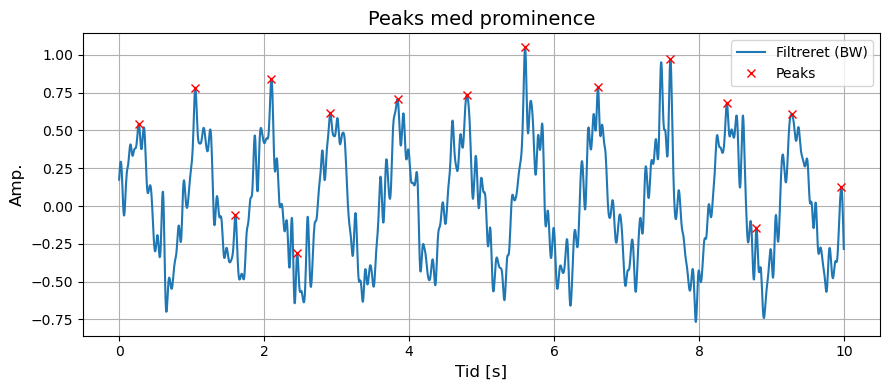

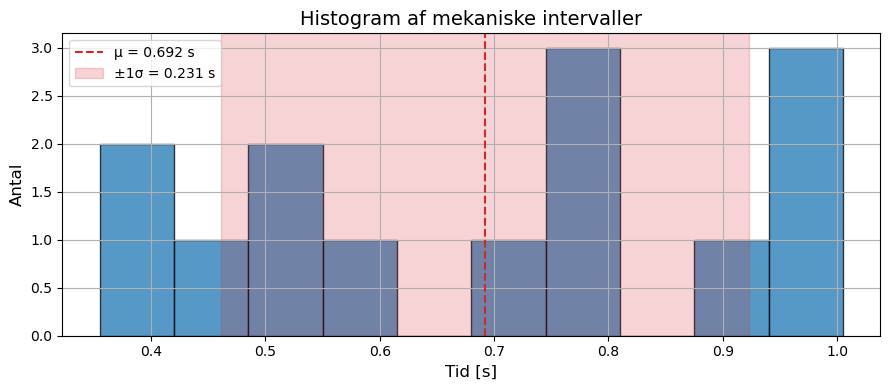

In [226]:
# Svarskitse – robust peak-detektion

from scipy.signal import find_peaks, butter, filtfilt
# Brug tidligere filtrerede y_bw hvis tilgængelig, ellers lav den nu
if 'y_bw' not in globals():
    b, a = butter(4, 15/(fs/2))
    y_bw = filtfilt(b, a, scg)
prom = 0.8*np.std(y_bw)
peaks, props = find_peaks(y_bw, prominence=prom, distance=int(0.35*fs))

intervals = np.diff(peaks)/fs
mu = np.mean(intervals) if len(intervals) else np.nan
sd = np.std(intervals, ddof=1) if len(intervals)>1 else 0.0

plt.figure(); plt.plot(t, y_bw, label='Filtreret (BW)')
plt.plot(t[peaks], y_bw[peaks], 'rx', label='Peaks')
plt.title('Peaks med prominence'); plt.xlabel('Tid [s]'); plt.ylabel('Amp.'); plt.legend(); plt.tight_layout(); plt.show()

if len(intervals) > 0:
    plt.figure(); plt.hist(intervals, bins=10, edgecolor='k', alpha=0.75)
    if np.isfinite(mu):
        plt.axvline(mu, color='C3', linestyle='--', label=f'μ = {mu:.3f} s')
        plt.axvspan(mu-sd, mu+sd, color='C3', alpha=0.2, label=f'±1σ = {sd:.3f} s')
    plt.title('Histogram af mekaniske intervaller'); plt.xlabel('Tid [s]'); plt.ylabel('Antal'); plt.legend(); plt.tight_layout(); plt.show()


## Synkronisering: R→S1 timing
**1. Scene og mål:** Relatér R‑peaks (ECG) til S1 i PCG og estimer mekanisk forsinkelse.  
**2. Værktøjer/udbytte:** `numpy`, `find_peaks`, simple vinduer efter R.  
**3. Opgave:** For hver R: søg AO i [60, 200] ms, beregn R→AO for alle slag, og fortolk fordelingen.

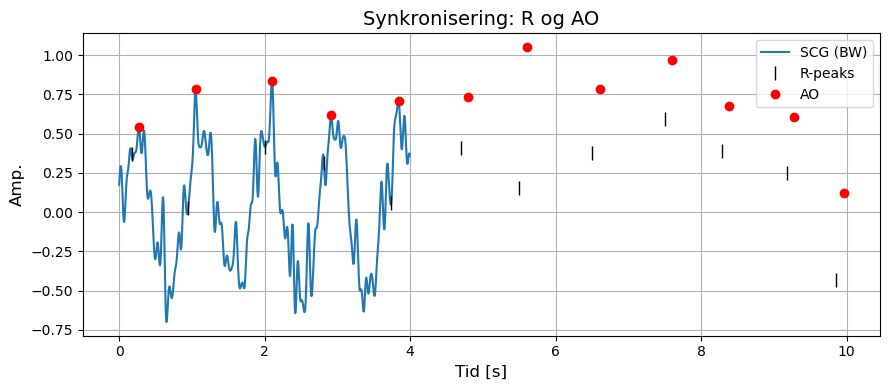

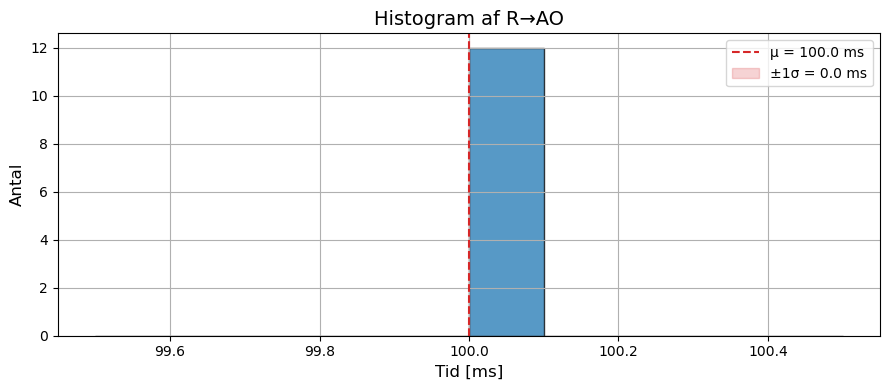

In [227]:
# Svarskitse – R→AO timing

from scipy.signal import find_peaks
tmp_peaks, _ = find_peaks(y_bw, prominence=0.8*np.std(y_bw), distance=int(0.5*fs))
r_peaks = (tmp_peaks - int(0.1*fs))
r_peaks = r_peaks[r_peaks>0]

r2ao = []
ao_idx = []
for rp in r_peaks:
    s = rp + int(0.06*fs)
    e = min(rp + int(0.20*fs), len(y_bw))
    seg = y_bw[s:e]
    if len(seg)==0: continue
    ao = s + np.argmax(seg)
    ao_idx.append(ao); r2ao.append((ao-rp)/fs)

r2ao = np.array(r2ao)

plt.figure();
sel = slice(0, min(len(t), int(4*fs)))
plt.plot(t[sel], y_bw[sel], label='SCG (BW)')
plt.plot(t[r_peaks], y_bw[r_peaks], 'k|', markersize=10, label='R-peaks')
plt.plot(t[ao_idx], y_bw[ao_idx], 'ro', label='AO')
plt.title('Synkronisering: R og AO'); plt.xlabel('Tid [s]'); plt.ylabel('Amp.'); plt.legend(); plt.tight_layout(); plt.show()

if len(r2ao)>0:
    mu, sd = np.mean(r2ao), np.std(r2ao, ddof=1) if len(r2ao)>1 else 0.0
    plt.figure(); plt.hist(r2ao*1e3, bins=10, edgecolor='k', alpha=0.75)
    plt.axvline(mu*1e3, color='C3', linestyle='--', label=f'μ = {mu*1e3:.1f} ms')
    plt.axvspan((mu-sd)*1e3, (mu+sd)*1e3, color='C3', alpha=0.2, label=f'±1σ = {sd*1e3:.1f} ms')
    plt.title('Histogram af R→AO'); plt.xlabel('Tid [ms]'); plt.ylabel('Antal'); plt.legend(); plt.tight_layout(); plt.show()


## Takeaways
- Brug **zero‑phase** (`filtfilt`) når timing er kritisk.  
- **Median** hjælper mod outliers; **Butterworth** for smooth amplitude-respons.  
- Motivér cut‑off med **PSD‑plots**.  
- Kommunikér variabilitet via **histogrammer** (μ og σ).